# Exponent Comparisons

This notebook compares methods that directly estimate aperiodic exponents, including:
- spectral parameterization
- IRASA

In [1]:
import numpy as np
from scipy.stats import ttest_rel

from neurodsp.sim import sim_powerlaw, sim_combined, sim_synaptic_current, sim_peak_oscillation
from neurodsp.utils import set_random_seed

from bootstrap import bootstrap_corr

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_comparisons
from apm.plts import plot_dots
from apm.plts.errors import plot_boxplot_errors, plot_violin_errors
from apm.plts.settings import EXT, METHOD_COLORS
from apm.methods import irasa, specparam
from apm.methods.settings import (SPECPARAM_PARAMS, SPECPARAM_PARAMS_KNEE,
                                  IRASA_PARAMS, IRASA_PARAMS_KNEE)
from apm.analysis.results import cohens_d
from apm.analysis.error import calculate_errors
from apm.sim.settings import (SIM_PARAMS_AP, SIM_PARAMS_COMB,
                              SIM_PARAMS_KNEE, SIM_PARAMS_PEAK)
from apm.sim.sim import sim_combined_peak
from apm.sim.params import sampler
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set number of simulations to run
N_SIMS = 1000

In [5]:
# Define measure settings
f_range = [1, 50]

In [6]:
# Define run settings
RETURN_SIM_PARAMS = True

In [7]:
# Plot settings
DOTS_KWARGS = {
    's' : 10, 
    'alpha' : 0.5,
    'color' : '#70706e',
    'xlabel' : 'Aperiodic Exponent (SP)', 
    'ylabel' : 'Aperiodic Exponent (IR)',
    'figsize' : (6, 5),
}

ERROR_PLT_KWARGS = {
    'labels' : ['SP', 'IR'],
    'palette' : METHOD_COLORS,
    'saturation' : 0.85,
    'width' : 0.7,
    'figsize' : (2.5, 2),
}

In [8]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '24_exp_comp'

In [9]:
# Set the random seed
set_random_seed(111)

### Collect Methods

In [10]:
# Define measures to apply
measures = {
    specparam : SPECPARAM_PARAMS,
    irasa : IRASA_PARAMS,
}
measures_knee = {
    specparam : SPECPARAM_PARAMS_KNEE,
    irasa : IRASA_PARAMS_KNEE,
}

## Simulations - Samples Across Aperiodic Signals 

In [11]:
# Define ranges to sample parameters from
samplers_ap = {'update_exp' : sampler(np.arange(-2.5, 0, 0.1))}

In [12]:
# Run simulations, comparing SpecParam & IRASA, sampling across aperiodic exponents
results_ap, sim_params_ap = run_comparisons(\
    sim_powerlaw, SIM_PARAMS_AP, measures, samplers_ap, N_SIMS, RETURN_SIM_PARAMS)

In [13]:
# Get the simulated exponent values
sim_exps_ap = -sim_params_ap.exponent.values

#### Errors

In [14]:
# Calculate errors of each method, as compared to ground truth simulations
errors_ap = calculate_errors(results_ap, sim_exps_ap)

In [67]:
# Check the errors per method, and the difference between them
for method in errors_ap.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_ap[method])))
print('\ndifference:\t{:1.4f}'.format(np.median(errors_ap['specparam']) - np.median(errors_ap['irasa'])))

specparam 	0.0501
irasa     	0.0185

difference:	0.0315


#### Statistical Difference

In [16]:
# Check the statistical difference between measure errors
ttest_rel(errors_ap['specparam'], errors_ap['irasa'])

TtestResult(statistic=26.353202290152986, pvalue=1.2614106273500653e-116, df=999)

#### Effect Size

In [17]:
# Compute the effect size of the difference between method errors
cohens_d(errors_ap['specparam'], errors_ap['irasa'])

1.1094193636911815

### Visualize

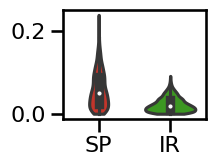

In [19]:
# Plot the errors - violinplot
plot_violin_errors(errors_ap, **ERROR_PLT_KWARGS)

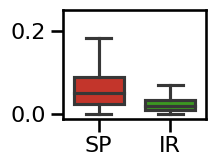

In [62]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_ap, **ERROR_PLT_KWARGS,
                    save_fig=SAVE_FIG, file_name='spec_irasa_exp_errors' + EXT, file_path=FIGPATH)

In [74]:
plot_dots?

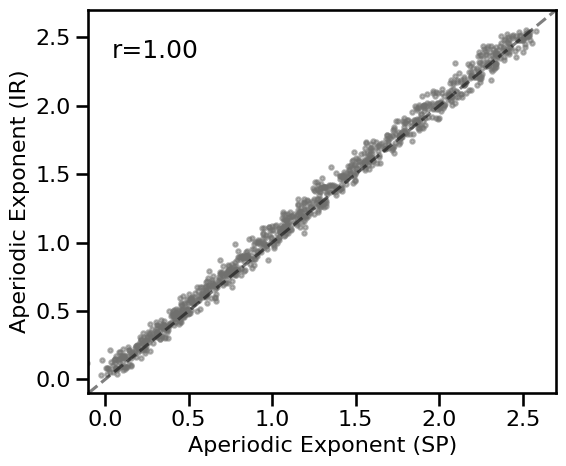

In [78]:
# Plot the comparison between specparam and IRASA
plot_dots(results_ap['specparam'], results_ap['irasa'], tposition='tl', **DOTS_KWARGS, 
          expected=[-0.1, 2.75], xlim=[-0.1, 2.7], ylim=[-0.1, 2.7],
          save_fig=SAVE_FIG, file_name='spec_irasa_exp' + EXT, file_path=FIGPATH)

In [22]:
# Check correlations
corrs_ap = bootstrap_corr(results_ap['specparam'], results_ap['irasa'])
print('  SP & IR:  ', format_corr(*corrs_ap))

  SP & IR:   r=+0.997  CI[+0.997, +0.997],  p=0.000


## Simulations - Samples Across Combined Signals 

In [23]:
# Define ranges to sample parameters from
samplers_comb = {'update_comb_exp' : sampler(np.arange(-2.5, 0, 0.1)),
                 'update_pow' : sampler(np.arange(0, 1, 0.1)),
                 'update_freq' : sampler(np.arange(5, 35, 1))}

In [24]:
# Run simulations, comparing SpecParam & IRASA, sampling across combined signal parameters
results_comb, sim_params_comb = run_comparisons(\
    sim_combined, SIM_PARAMS_COMB, measures, samplers_comb, N_SIMS, RETURN_SIM_PARAMS)

In [25]:
# Get the simulated exponent values
sim_exps_comb = -sim_params_comb.exponent.values

#### Errors

In [26]:
# Calculate errors of each method, as compared to ground truth simulations
errors_comb = calculate_errors(results_comb, sim_exps_comb)

In [69]:
# Check the errors per method
for method in errors_comb.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_comb[method])))
print('\ndifference:\t{:1.4f}'.format(np.median(errors_comb['specparam']) - np.median(errors_comb['irasa'])))

specparam 	0.0322
irasa     	0.0208

difference:	0.0114


#### Statistical Difference

In [28]:
# Check the statistical difference between measure errors
ttest_rel(errors_comb['specparam'], errors_comb['irasa'])

TtestResult(statistic=14.067819648883063, pvalue=3.829143788381139e-41, df=999)

#### Effect Size

In [29]:
# Compute the effect size of the difference between method errors
cohens_d(errors_comb['specparam'], errors_comb['irasa'])

0.584259746181894

### Visualize

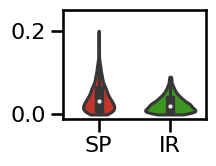

In [31]:
# Plot the errors - violinplot
plot_violin_errors(errors_comb, **ERROR_PLT_KWARGS, ylim=[-0.01, 0.25])


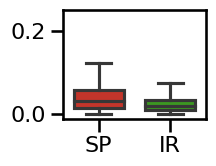

In [32]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_comb, ylim=[-0.01, 0.25], **ERROR_PLT_KWARGS,
                   save_fig=SAVE_FIG, file_name='spec_irasa_comb_errors' + EXT, file_path=FIGPATH)

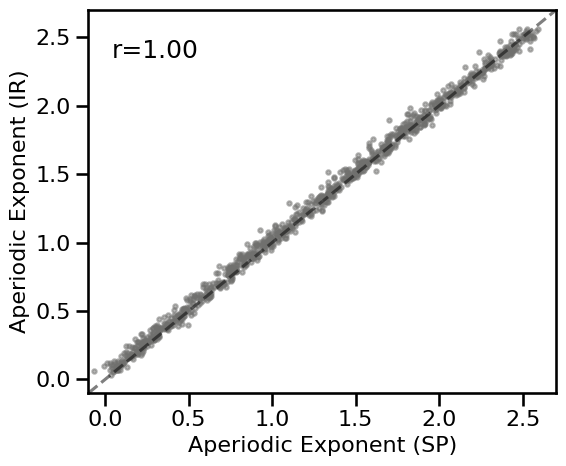

In [79]:
# Plot the comparison between specparam and IRASA
plot_dots(results_comb['specparam'], results_comb['irasa'], tposition='tl', **DOTS_KWARGS,
          expected=[-0.1, 2.75], xlim=[-0.1, 2.7], ylim=[-0.1, 2.7],
          save_fig=SAVE_FIG, file_name='spec_irasa_comb' + EXT, file_path=FIGPATH)

In [34]:
# Check correlations
corrs_comb = bootstrap_corr(results_comb['specparam'], results_comb['irasa'])
print('  SP & IR:  ', format_corr(*corrs_comb))

  SP & IR:   r=+0.998  CI[+0.998, +0.998],  p=0.000


## Simulations - Samples Across Knee Signals

In [35]:
# Define ranges to sample parameters from
samplers_knee = {'update_knee' : sampler(np.arange(0.005, 0.075, 0.010))}

In [36]:
# Run simulations, comparing SpecParam & IRASA, sampling across timescale / knee values
results_knee, sim_params_knee = run_comparisons(\
    sim_synaptic_current, SIM_PARAMS_KNEE, measures_knee, samplers_knee, N_SIMS, RETURN_SIM_PARAMS)

In [38]:
# Define the expected aperiodic exponent for the synapse knee model
sim_exps_knee = np.ones(N_SIMS) * 2

#### Errors

In [40]:
# Calculate errors of each method, as compared to ground truth simulations
errors_knee = calculate_errors(results_knee, sim_exps_knee)

In [70]:
# Check the errors per method
for method in errors_knee.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_knee[method])))
print('\ndifference:\t{:1.4f}'.format(np.median(errors_knee['specparam']) - np.median(errors_knee['irasa'])))

specparam 	0.0567
irasa     	0.1044

difference:	-0.0477


#### Statistical Test

In [42]:
# Check the statistical difference between measure errors
ttest_rel(errors_knee['specparam'], errors_knee['irasa'])

TtestResult(statistic=-22.748893553653424, pvalue=1.2165049690883563e-92, df=999)

#### Effect Size

In [43]:
# Compute the effect size of the difference between method errors
cohens_d(errors_knee['specparam'], errors_knee['irasa'])

-0.7168990336785336

### Visualize

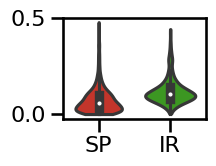

In [46]:
# Plot the errors - violinplot
plot_violin_errors(errors_knee, **ERROR_PLT_KWARGS)

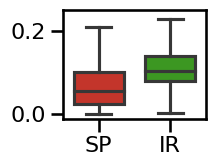

In [80]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_knee, ylim=[-0.01, 0.25], **ERROR_PLT_KWARGS,
                    save_fig=SAVE_FIG, file_name='spec_irasa_knee_errors' + EXT, file_path=FIGPATH)

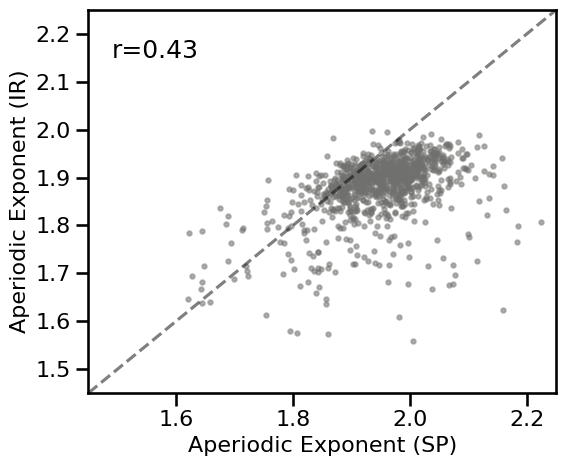

In [87]:
# Plot the comparison between specparam and IRASA
plot_dots(results_knee['specparam'], results_knee['irasa'], tposition='tl',
          expected=[1.45, 2.25], xlim=[1.45, 2.25], ylim=[1.45, 2.25], **DOTS_KWARGS,
          save_fig=SAVE_FIG, file_name='spec_irasa_knee' + EXT, file_path=FIGPATH)

In [48]:
# Check correlations
corrs_knee = bootstrap_corr(results_knee['specparam'], results_knee['irasa'])
print('  SP & IR:  ', format_corr(*corrs_knee))

  SP & IR:   r=+0.431  CI[+0.372, +0.489],  p=0.000


## Simulations - Samples Across Peak Signals 

In [50]:
# Define ranges to sample parameters from
samplers_bw = {'update_comb_exp' : sampler(np.arange(-2.5, 0, 0.1)),
               'update_peak_freq' : sampler(np.arange(8, 30, 1)),
               'update_peak_hgt' : sampler(np.arange(1.0, 2.25, 0.25)),
               'update_peak_bw' : sampler(np.arange(1.0, 4.5, 0.5))}

In [51]:
# Run simulations, comparing SpecParam & IRASA, sampling across timescale / knee values
results_bw, sim_params_bw = run_comparisons(\
    sim_combined_peak, SIM_PARAMS_PEAK, measures, samplers_bw, N_SIMS, RETURN_SIM_PARAMS)

In [52]:
# Get the simulated exponent values
sim_exps_bw = -sim_params_bw.exponent.values

In [53]:
# Calculate errors of each method, as compared to ground truth simulations
errors_bw = calculate_errors(results_bw, sim_exps_bw)

#### Errors

In [72]:
# Check the errors per method
for method in errors_bw.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.median(errors_bw[method])))
print('\ndifference:\t{:1.4f}'.format(np.median(errors_bw['specparam']) - np.median(errors_bw['irasa'])))

specparam 	0.0499
irasa     	0.1105

difference:	-0.0607


#### Statistical Difference

In [55]:
# Check the statistical difference between measure errors
ttest_rel(errors_bw['specparam'], errors_bw['irasa'])

TtestResult(statistic=-21.15645011101932, pvalue=2.21520635821354e-82, df=999)

#### Effect Size

In [56]:
# Compute the effect size of the difference between method errors
cohens_d(errors_bw['specparam'], errors_bw['irasa'])

-0.8961169373442495

### Visualize

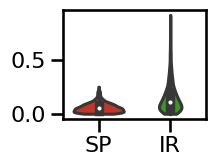

In [73]:
# Plot the errors - violinplot
plot_violin_errors(errors_bw, **ERROR_PLT_KWARGS)

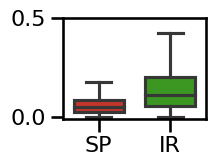

In [58]:
# Plot the errors - boxplot
plot_boxplot_errors(errors_bw, ylim=[-0.01, 0.50], **ERROR_PLT_KWARGS,
                    save_fig=SAVE_FIG, file_name='spec_irasa_bw_errors' + EXT, file_path=FIGPATH)

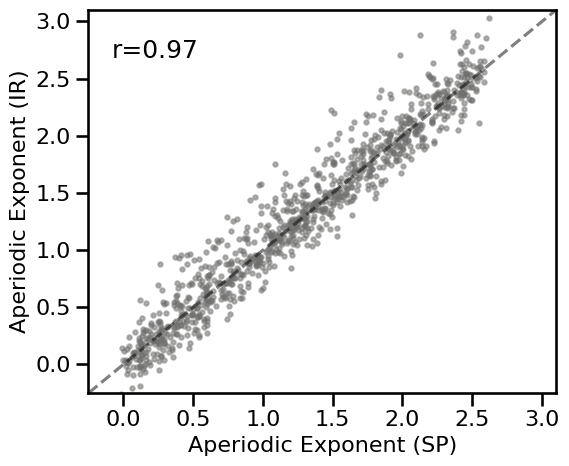

In [88]:
# Plot the comparison between specparam and IRASA
plot_dots(results_bw['specparam'], results_bw['irasa'], tposition='tl', **DOTS_KWARGS,
          expected=[-0.25, 3.1], xlim=[-0.25, 3.1], ylim=[-0.25, 3.1],
          save_fig=SAVE_FIG, file_name='spec_irasa_bw' + EXT, file_path=FIGPATH)

In [61]:
# Check correlation
corrs_bw = bootstrap_corr(results_bw['specparam'], results_bw['irasa'])
print('  SP & IR:  ', format_corr(*corrs_bw))

  SP & IR:   r=+0.972  CI[+0.968, +0.975],  p=0.000


## Conclusions

Comparing between these methods, overall we can see that:
- In simple cases (powerlaw + oscillations), specparam and IRASA perform very similarly